Here I develop code to generate training examples. The process might look like this:

1. I sample two images. For a start, I can pick two images e.g. 1 year apart
2. I get the intersection of their extents
3. I get the subset of deter polygons within the intersection and within the time window
4. I rasterize/mask the polygons from set 3.
5. I iterate through the area; if there are no no-data values in neither of two images, i generate a patch and a corresponding label

In [88]:
import glob
import os
from pathlib import Path
import matplotlib.pyplot as plt

from shapely.geometry import box, Polygon
import numpy as np
import pandas as pd
import rasterio
from rasterio.windows import get_data_window, transform, shape
import geopandas as gpd
import pandas as pd
from pandas import Timestamp
from rasterio.mask import mask

In [147]:
image_1_path = '../data/aoi_1/raster/2019_2021_processed/2019_07_16.tif'
image_2_path = '../data/aoi_1/raster/2019_2021_processed/2020_07_15.tif'

temp_dir = '../data/aoi_1/raster/workdir/'


deter_path = '../data/sample_data/DETER/deter_public.shp'

In [148]:
margin_days = 31
margin = pd.to_timedelta(margin_days, unit='d')

raster_crs = 32722


In [149]:
def get_raster_bounds(path: str) -> Polygon:
    """Open raster and return its extent/bounds

    Args:
        path (str): path to tif file

    Returns:
        Polygon: extent of the raster as a shapely Polygon
    """
    with rasterio.open(path) as src:
        geom = box(*src.bounds)
    
    return geom

In [150]:
def get_raster_date(path: str) -> Timestamp:
    """Extract date from file name

    Args:
        path (str): path to raster file; expects certain naming conventions

    Returns:
        pandas Timestamp: date of acquisition of this raster
    """

    filename = Path(path).stem
    date = pd.to_datetime(filename.replace("_", "-"))

    return date


In [151]:
bounds_1 = get_raster_bounds(image_1_path)
bounds_2 = get_raster_bounds(image_2_path)
intersection = bounds_1.intersection(bounds_2)

In [152]:
start_date = get_raster_date(image_1_path)
end_date = get_raster_date(image_2_path)

In [153]:
deter = gpd.read_file(deter_path).to_crs(raster_crs)

In [154]:
deter_spatial_subset = deter.loc[deter.intersects(intersection)].copy()
deter_spatial_subset['date'] = pd.to_datetime(deter_spatial_subset.VIEW_DATE)

In [155]:
deter_temporal_subset = deter_spatial_subset.loc[
    (deter_spatial_subset['date'] > (start_date + margin).strftime('%Y-%m-%d')) 
    & (deter_spatial_subset['date'] < (end_date - margin).strftime('%Y-%m-%d'))]

deter_subset = deter_temporal_subset

In [166]:
template_raster_path = os.path.join(temp_dir, 'segm_mask.tif')

with rasterio.open(image_1_path) as src:
    out_image, out_transform = mask(src, [geom for geom in deter_subset.geometry], crop=True)
    out_meta = src.meta

    out_image = out_image[:1]
    out_image[out_image > 0] = 1


out_meta.update({"driver": "GTiff",
                "height": out_image.shape[1],
                "width": out_image.shape[2],
                "count": 1,
                "transform": out_transform})


with rasterio.open(template_raster_path, "w", **out_meta) as dest:
    dest.write(out_image)

I have produced the segmentation mask for a given pair of images. As expected, the vast majority of pixels is negative. I think that a possible solution could be

1. for each of the subset of deter polygons, get its bbox
2. buffer the bbox by some value
3. maybe do some kind of union to get rid of areas being included multiple times (as a result of nearby polygons + buffer)
4. for each separate polygon, clip this polygon from the input and output rasters
5. then for each of these, as specified before, iterate through them and extract valid patches

In [173]:
# The envelope of a geometry is the bounding rectangle. 
# That is, the point or smallest rectangular polygon 
# (with sides parallel to the coordinate axes) that contains the geometry.

deter_subset['bbox'] = deter_subset.envelope.buffer(100)

2953      POLYGON ((176370.104 9324777.053, 176836.168 9...
3855      POLYGON ((232375.306 9331097.691, 233255.733 9...
3946      POLYGON ((242097.082 9320874.005, 242915.176 9...
4047      POLYGON ((230803.350 9316704.615, 231078.747 9...
4063      POLYGON ((226269.229 9318802.844, 226921.584 9...
                                ...                        
180022    POLYGON ((185422.950 9347329.980, 185904.308 9...
180551    POLYGON ((242438.383 9320852.635, 242884.955 9...
180565    POLYGON ((245225.401 9324017.877, 245506.408 9...
182038    POLYGON ((248298.940 9324116.119, 249040.465 9...
184462    POLYGON ((233745.644 9359213.899, 234258.943 9...
Length: 211, dtype: geometry

In [181]:
def write_patch(row, index, image_path, out_dir):

    out_name = str(index) + "_" + Path(image_path).name
    out_path = os.path.join(out_dir, out_name)

    with rasterio.open(image_path) as src:
        out_image, out_transform = mask(src, [row.bbox], crop=True)
        out_meta = src.meta

    out_meta.update({"driver": "GTiff",
                    "height": out_image.shape[1],
                    "width": out_image.shape[2],
                    "transform": out_transform})


    with rasterio.open(out_path, "w", **out_meta) as dest:
        dest.write(out_image)

In [182]:
out_dir = '../data/aoi_1/raster/workdir/examples'

for idx, row in deter_subset.iterrows():
    write_patch(row, idx, image_1_path, out_dir)
    write_patch(row, idx, image_2_path, out_dir)




In [158]:
#deter_subset['geometry'] = deter_subset['bbox']
deter_subset = deter_temporal_subset.drop(['date'], axis=1)
deter_subset.to_file("../data/aoi_1/vector/workdir/deter_subset_2019_07_16___2020_07_15.shp")

/Users/janpisl/miniconda3/envs/gee/lib/python3.9/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [187]:
deter_temporal_subset['geometry'] = deter_temporal_subset.envelope.buffer(100).copy()

/Users/janpisl/miniconda3/envs/gee/lib/python3.9/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


<AxesSubplot:>

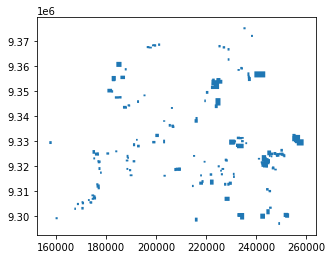

In [192]:
x= deter_temporal_subset.dissolve().explode()
x.plot()